## SPECIFICHE DEL PROGETTO
Previsione di opportunità di Cross Sell di assicurazioni
Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

1. id: id univoco dell'acquirente.

2. Gender: sesso dell'acquirente.

3. Age: età dell'acquirente.

4. Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.

5. Region_Code: codice univoco della regione dell'acquirente.

6. Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.

7. Vehicle_Age: età del veicolo

8. Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.

9. Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.

10. Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)

11. Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.

12. Response: 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.


L'obiettivo del modello è prevedere il valore di Response.

Tip Fai attenzione alla distribuzione delle classi, dai uno sguardo a questo approfondimento. In caso di classi sbilanciate puoi provare a:

Penalizzare la classe più frequente (ricorda l'argomento class_weight)
Utilizzare l'oversampling o l'undersampling.

### LIBRERIE E FUNZIONI UTILI
Il progetto in questione consiste in un problema di classificazione binaria, importiamo le funzioni e librerie che potrebbero esserci utili; progressivamente, secondo le esigenze, aggiorneró la lista passo passo.

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold,cross_validate
from sklearn.metrics import make_scorer
from scipy.stats import f_oneway
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import TomekLinks
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline as ImbPipeline

### IMPORTAZIONE DEL DATASET, OCCHIATA GENERALE.

In [113]:
df = pd.read_csv('//content//drive//MyDrive//Progetto assicurazione machine learning base//insurance_cross_sell.csv', index_col=[0])

## Controlliamo le prime 5 osservazioni del dataset

In [114]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Controlliamo le distribuzioni delle diverse variabili

In [115]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


## Controlliamo la tipologia di variabile

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


Controlliamo la presenza di dati mancanti

In [117]:
df.isnull().sum()

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


Andiamo a controllare la distribuzione della nostra variabile di risposta per essere sicuri che sia equidistribuita.

In [118]:
counts = df['Response'].value_counts()
print(counts)
print(f"risposta negativa= {counts.iloc[0]} ({counts.iloc[0]/counts.sum()*100:.2f}%)")
print(f"risposta positiva= {counts.iloc[1]} ({counts.iloc[1]/counts.sum()*100:.2f}%)")

Response
0    334399
1     46710
Name: count, dtype: int64
risposta negativa= 334399 (87.74%)
risposta positiva= 46710 (12.26%)


come possiamo notare la nostra variabile di risposta é fortemente sbilanciata.

### ANALISI DELLE VARIABILI
Procediamo all'analisi delle variabili per cercare correlazioni importanti con la nostra variabile di risposta.

## Analisi variabili numeriche continue, Plottaggio.

Text(0.5, 1.0, 'Boxplot Vintage/Response')

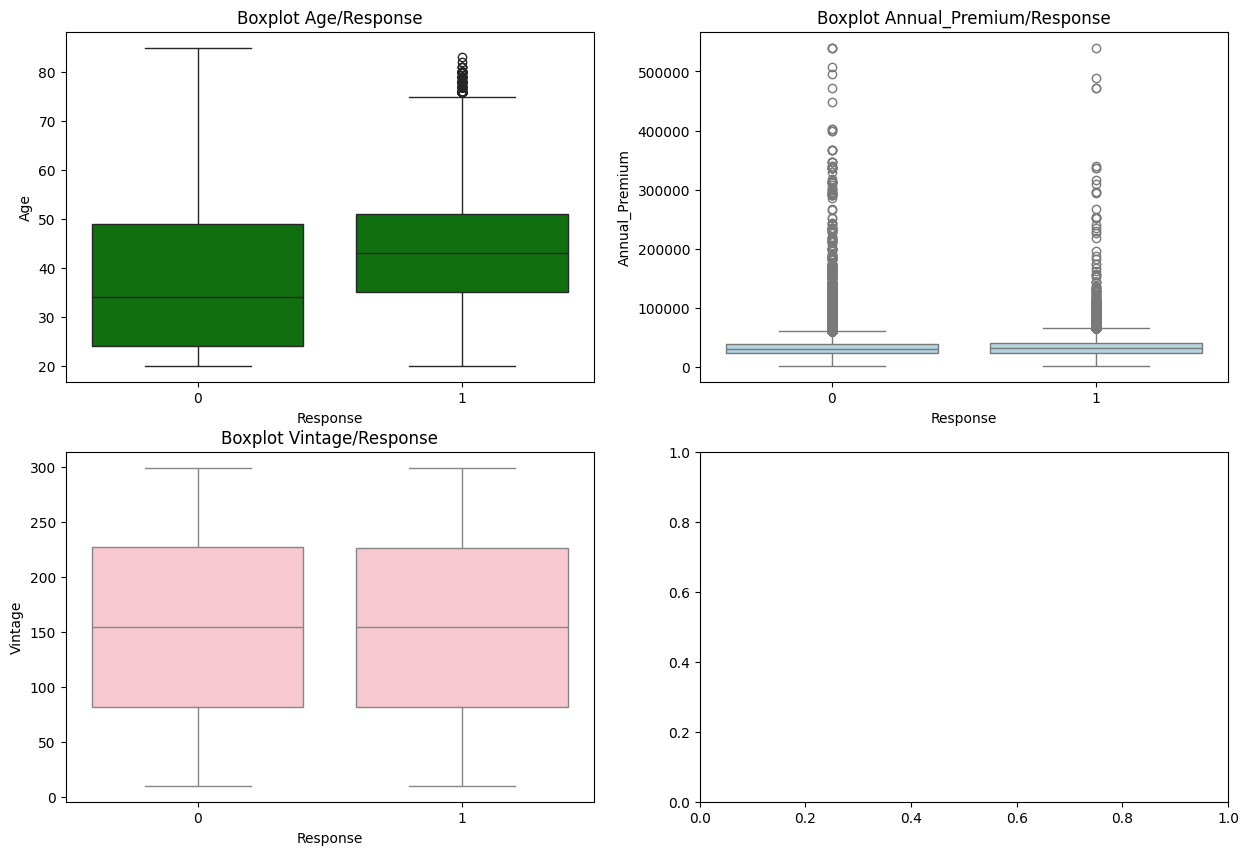

In [119]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='Response', y='Age', data=df, ax=axes[0,0], color = 'green')
axes[0, 0].set_title('Boxplot Age/Response')
sns.boxplot(x='Response', y='Annual_Premium', data=df, ax=axes[0,1], color = 'lightblue')
axes[0, 1].set_title('Boxplot Annual_Premium/Response')
sns.boxplot(x='Response', y='Vintage', data=df, ax=axes[1,0], color = 'pink')
axes[1, 0].set_title('Boxplot Vintage/Response')

Apparentemente, a livello visivo la variabile che apporta maggiore informazione sembra essere unicamente l'etá (Age), effettuiamo un test statistico (Anova), per valutare se effettivamente la variazione sia statisticamente significativa oppure se la varibile non apporta modifiche significative al modello.

## Test Anova variabili numeriche continue VS response

In [120]:
def anova_test(df, feature, target):
    group1 = df[df[target] == 0][feature]
    group2 = df[df[target] == 1][feature]
    f_stat, p_value = f_oneway(group1, group2)
    return f_stat, p_value

In [121]:
for feature in ['Age', 'Annual_Premium', 'Vintage']:
    f_stat, p_value = anova_test(df, feature, 'Response')
    print(f'ANOVA per {feature}:\nF-statistic: {f_stat:.3f}, P-value: {p_value:.3f}')

ANOVA per Age:
F-statistic: 4766.945, P-value: 0.000
ANOVA per Annual_Premium:
F-statistic: 194.318, P-value: 0.000
ANOVA per Vintage:
F-statistic: 0.420, P-value: 0.517


Dal test emerge che le variabili che apportano informazioni al mio dataset sono Age e Annual Premium avendo fatto registrare un valore di p_value inferiore alla soglia 0.05. Procediamo con l'eliminazione della variabile Vintage dal nostro dataset.

## Eliminazione dal dataset variabile Vintage

In [122]:
df = df.drop('Vintage', axis=1)
df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
id,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,0
...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,0
381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,0
381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,0


## Analisi variabili categoriche in relazione a Response, test chi quadro.

Costruiamo le tabelle di contigenza per le varaibili categoriche e andiamo ad effettuare un test del chi_quadro.

In [123]:
def chi_square_test(df, categorical_var, target):
    contingency_table = pd.crosstab(df[categorical_var], df[target])
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2_stat, p_value

In [124]:
categorical_vars = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
for var in categorical_vars:
    chi2_stat, p_value = chi_square_test(df, var, 'Response')
    print(f"Test del Chi-Quadro per {var}:\nChi-square statistic: {chi2_stat:.3f}, P-value: {p_value:.3f}\n")

Test del Chi-Quadro per Gender:
Chi-square statistic: 1047.708, P-value: 0.000

Test del Chi-Quadro per Driving_License:
Chi-square statistic: 38.634, P-value: 0.000

Test del Chi-Quadro per Region_Code:
Chi-square statistic: 7267.842, P-value: 0.000

Test del Chi-Quadro per Previously_Insured:
Chi-square statistic: 44357.965, P-value: 0.000

Test del Chi-Quadro per Vehicle_Age:
Chi-square statistic: 18771.890, P-value: 0.000

Test del Chi-Quadro per Vehicle_Damage:
Chi-square statistic: 47864.762, P-value: 0.000

Test del Chi-Quadro per Policy_Sales_Channel:
Chi-square statistic: 26447.033, P-value: 0.000



I test del chi quadro hanno fatto registrare valori tutti inferiori a 0.05 quindi teoricamente sono tutte importanti, tuttavia plotterei dei grafici a barre sovrapposti per vedere effettivamente come si distribuisce l'incidenza dei si e dei no su tutte le differenti features soprattuto con le variabili aventi il maggior numero di features, e qualora trovassi discrepenze notevoli imputabili a determinate classi andrei ad approfondire ulteriormente l'apporto fornito dalle singole classi al valore del chi quadro.

## Analisi variabili categoriche in relazione a Response Reagion_code.

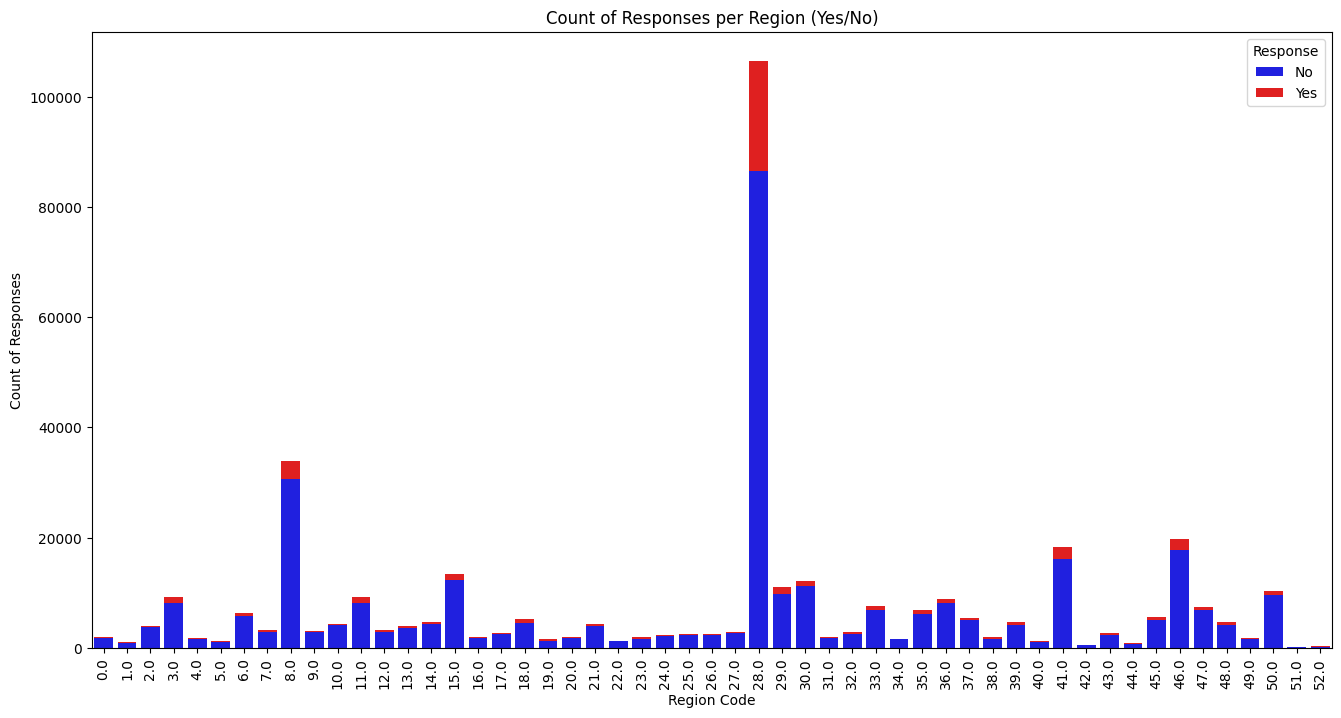

In [125]:
response_counts_Region_code = pd.crosstab(df['Region_Code'], df['Response'])
response_counts_Region_code.columns = ['No', 'Yes']
plt.figure(figsize=(16, 8))
sns.barplot(x=response_counts_Region_code.index, y=response_counts_Region_code['No'], color='blue', label='No')
sns.barplot(x=response_counts_Region_code.index, y=response_counts_Region_code['Yes'], color='red', label='Yes', bottom=response_counts_Region_code['No'])
plt.xlabel('Region Code')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Region (Yes/No)')
plt.xticks(rotation=90)
plt.legend(title='Response')
plt.show()

Dal grafico appare evidente come la distribuzione dei si e dei divise per regione siano molto squilibrate. Andiamo a verificare l'opporto al chi quadro di ogni singola regione.

In [126]:
contingency_table = pd.crosstab(df['Region_Code'], df['Response'])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
contributions = (contingency_table - expected) ** 2 / expected
contributions['Total'] = contributions.sum(axis=1)
contributions_sorted = contributions['Total'].sort_values(ascending=False)
print("Contributo Individuale al Chi-Quadro per Classe:")
print(contributions_sorted)

Contributo Individuale al Chi-Quadro per Classe:
Region_Code
28.0    4129.455954
50.0     341.591707
15.0     316.544950
30.0     269.280923
8.0      219.908163
6.0      161.929816
10.0     158.548888
36.0     148.795991
25.0     148.268793
21.0     105.360202
2.0       99.543195
37.0      95.927294
38.0      90.842648
47.0      84.131964
46.0      71.067174
17.0      66.445232
27.0      61.820257
26.0      60.812222
16.0      58.102299
44.0      50.177675
9.0       48.417339
14.0      45.534048
22.0      42.595475
13.0      39.336506
49.0      38.893074
33.0      38.535659
32.0      35.111275
34.0      33.950924
0.0       24.991870
19.0      23.185080
43.0      22.238943
4.0       21.322449
12.0      18.589381
48.0      18.582724
23.0      16.951904
42.0      12.721576
31.0       8.863825
45.0       8.592558
11.0       8.250351
24.0       8.150817
18.0       3.890268
7.0        2.571819
3.0        2.236142
1.0        1.951295
51.0       1.576972
20.0       0.963553
5.0        0.557720

In [127]:
significant_cells_Region_code = contributions[contributions>0.05*chi2_stat]
with pd.option_context('display.max_rows', None):
    print(significant_cells_Region_code)

Response              0            1        Total
Region_Code                                      
0.0                 NaN          NaN          NaN
1.0                 NaN          NaN          NaN
2.0                 NaN          NaN          NaN
3.0                 NaN          NaN          NaN
4.0                 NaN          NaN          NaN
5.0                 NaN          NaN          NaN
6.0                 NaN          NaN          NaN
7.0                 NaN          NaN          NaN
8.0                 NaN          NaN          NaN
9.0                 NaN          NaN          NaN
10.0                NaN          NaN          NaN
11.0                NaN          NaN          NaN
12.0                NaN          NaN          NaN
13.0                NaN          NaN          NaN
14.0                NaN          NaN          NaN
15.0                NaN          NaN          NaN
16.0                NaN          NaN          NaN
17.0                NaN          NaN          NaN


La Features che apporta effettivmante informazione é la 28. Andiamo a trasformare la variabile regione in una variabile dummies selezionadno unicamente la categoria che abbiamo visto essere l'unica effettivamente importante, ed eliminiamo la colonna delle regioni.

In [128]:
significant_category_Region_code = 28.0
df['is_region_28'] = df['Region_Code'] == significant_category_Region_code
df['is_region_28'] = df['is_region_28'].astype(int)
df = df.drop(['Region_Code'], axis=1)
df

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,is_region_28
id,,,,,,,,,,
1,Male,44,1,0,> 2 Years,Yes,40454.0,26.0,1,1
2,Male,76,1,0,1-2 Year,No,33536.0,26.0,0,0
3,Male,47,1,0,> 2 Years,Yes,38294.0,26.0,1,1
4,Male,21,1,1,< 1 Year,No,28619.0,152.0,0,0
5,Female,29,1,1,< 1 Year,No,27496.0,152.0,0,0
...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,1,1,1-2 Year,No,30170.0,26.0,0,0
381106,Male,30,1,1,< 1 Year,No,40016.0,152.0,0,0
381107,Male,21,1,1,< 1 Year,No,35118.0,160.0,0,0


## Analisi variabili categoriche in realazione a Response Policy_Sales_channel

Procederó in modo analogo alla precedente variabile.

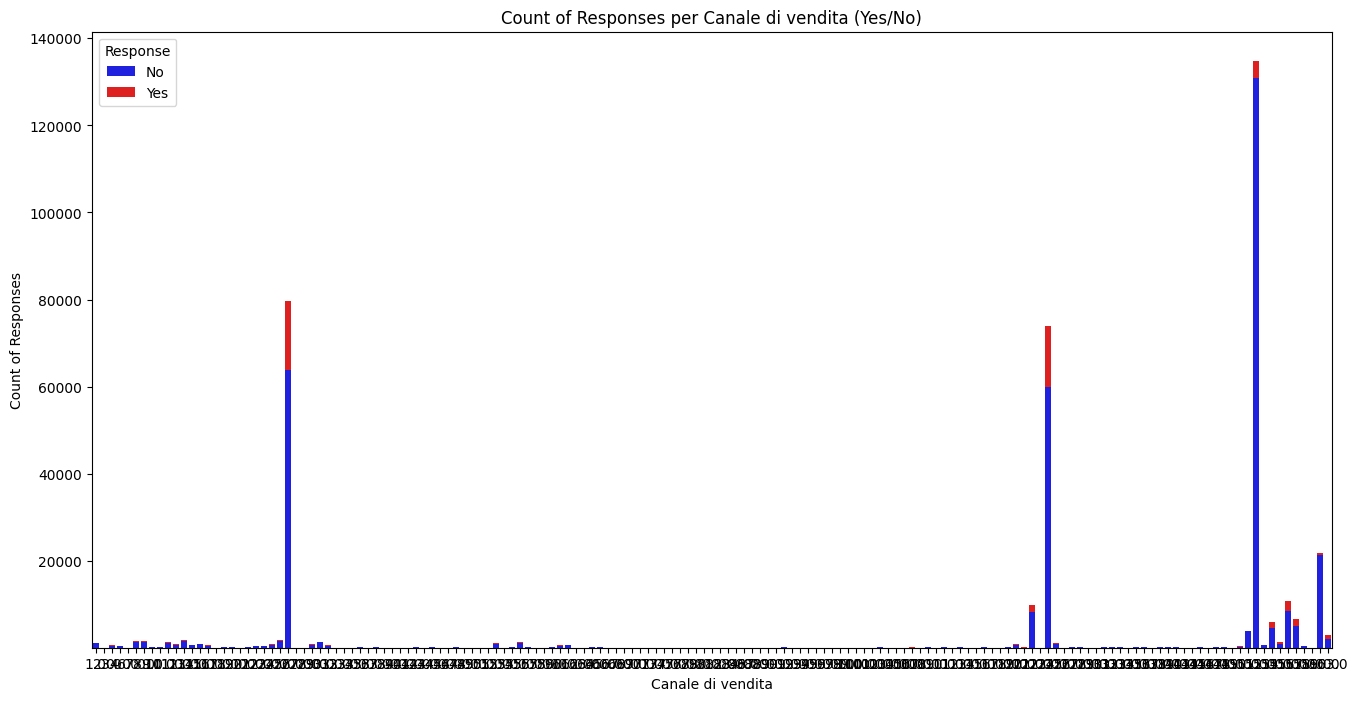

In [129]:
response_counts_Policy_Sales_Channel = pd.crosstab(df['Policy_Sales_Channel'], df['Response'])
response_counts_Policy_Sales_Channel.columns = ['No', 'Yes']
plt.figure(figsize=(16,8))
sns.barplot(x = response_counts_Policy_Sales_Channel.index, y = response_counts_Policy_Sales_Channel['No'], color='blue', label='No')
sns.barplot(x = response_counts_Policy_Sales_Channel.index, y = response_counts_Policy_Sales_Channel['Yes'], color='red', label='Yes', bottom=response_counts_Policy_Sales_Channel['No'] )
plt.xlabel('Canale di vendita')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Canale di vendita (Yes/No)')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.show()

In [130]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(response_counts_Policy_Sales_Channel)
contributions = (response_counts_Policy_Sales_Channel - expected) ** 2 / expected
contributions['Total'] = contributions.sum(axis=1)
contributions_sorted = contributions['Total'].sort_values(ascending=False)
print("Contributo Individuale al Chi-Quadro per Classe 5%:")
significant_cells_Policy_Sales_Channel = contributions[contributions>0.05*chi2_stat]
with pd.option_context('display.max_rows', None):
    print(significant_cells_Policy_Sales_Channel )

Contributo Individuale al Chi-Quadro per Classe 5%:
                              No          Yes         Total
Policy_Sales_Channel                                       
1.0                          NaN          NaN           NaN
2.0                          NaN          NaN           NaN
3.0                          NaN          NaN           NaN
4.0                          NaN          NaN           NaN
6.0                          NaN          NaN           NaN
7.0                          NaN          NaN           NaN
8.0                          NaN          NaN           NaN
9.0                          NaN          NaN           NaN
10.0                         NaN          NaN           NaN
11.0                         NaN          NaN           NaN
12.0                         NaN          NaN           NaN
13.0                         NaN          NaN           NaN
14.0                         NaN          NaN           NaN
15.0                         NaN          NaN   

26,124,152,160 sono le features con apporto al chi quadro maggiore del 5%. Porcediamo alla creazione delle nuove colonne per le nuove variabili all'encoding e alla rimozione della variabile policy_sales_channel.

In [131]:
significant_category_channel_code = [26.0, 124.0, 152.0, 160.0]
for category in significant_category_channel_code:
    df[f'is_channel_{category}'] = (df['Policy_Sales_Channel'] == category).astype(int)

df = df.drop(['Policy_Sales_Channel'], axis=1)
df

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,is_region_28,is_channel_26.0,is_channel_124.0,is_channel_152.0,is_channel_160.0
id,,,,,,,,,,,,,
1,Male,44,1,0,> 2 Years,Yes,40454.0,1,1,1,0,0,0
2,Male,76,1,0,1-2 Year,No,33536.0,0,0,1,0,0,0
3,Male,47,1,0,> 2 Years,Yes,38294.0,1,1,1,0,0,0
4,Male,21,1,1,< 1 Year,No,28619.0,0,0,0,0,1,0
5,Female,29,1,1,< 1 Year,No,27496.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,1,1,1-2 Year,No,30170.0,0,0,1,0,0,0
381106,Male,30,1,1,< 1 Year,No,40016.0,0,0,0,0,1,0
381107,Male,21,1,1,< 1 Year,No,35118.0,0,0,0,0,0,1


## Analisi variabili categoriche in realazione a Response: Vehicle_Age

In [132]:
df['Vehicle_Age'].value_counts()

,count
Vehicle_Age,
1-2 Year,200316
< 1 Year,164786
> 2 Years,16007


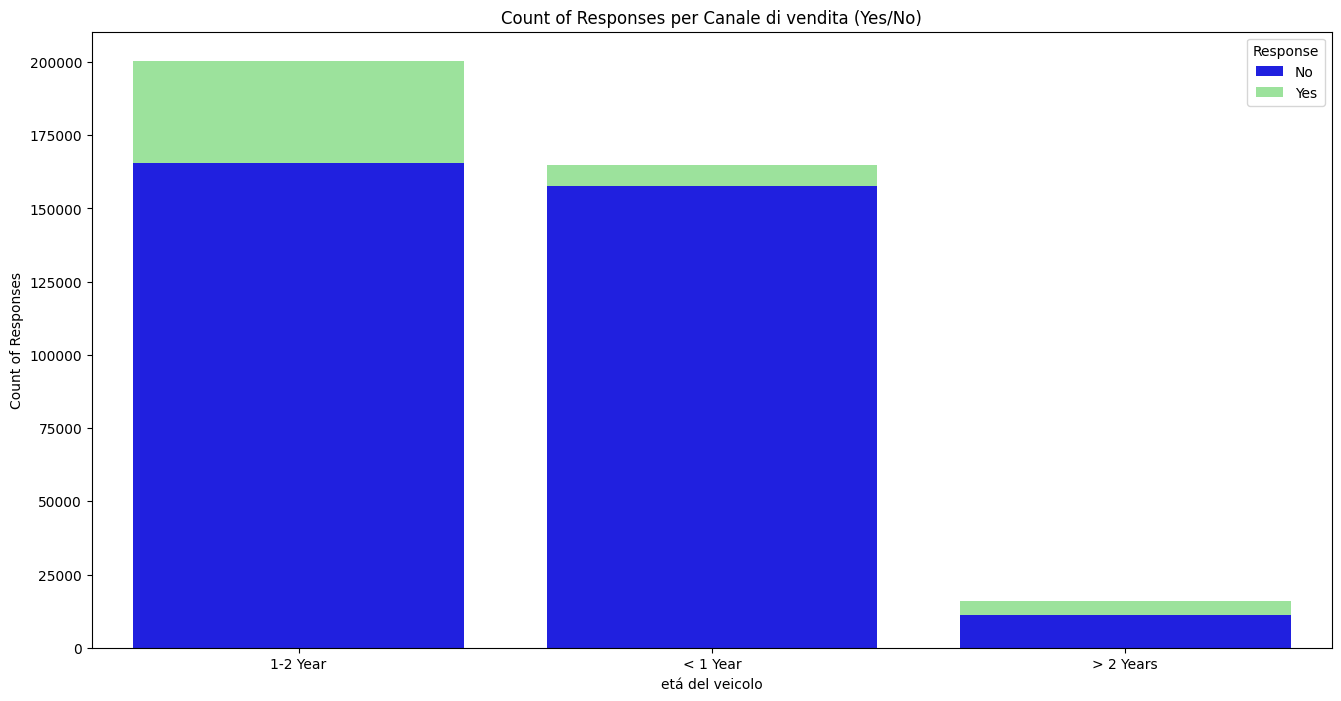

In [133]:
response_counts_Veichle_Age = pd.crosstab(df['Vehicle_Age'], df['Response'])
response_counts_Veichle_Age.columns = ['No', 'Yes']
plt.figure(figsize=(16,8))
sns.barplot(x = response_counts_Veichle_Age.index, y = response_counts_Veichle_Age['No'], color='blue', label='No')
sns.barplot(x = response_counts_Veichle_Age.index, y = response_counts_Veichle_Age['Yes'], color='lightgreen', label='Yes', bottom=response_counts_Veichle_Age['No'] )
plt.xlabel('etá del veicolo')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Canale di vendita (Yes/No)')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.show()

In [134]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(response_counts_Veichle_Age)

contributions = (response_counts_Veichle_Age - expected) ** 2 / expected

contributions['Total'] = contributions.sum(axis=1)

contributions_sorted = contributions['Total'].sort_values(ascending=False)

print("Contributo Individuale al Chi-Quadro per Classe:")
with pd.option_context('display.max_rows', None):
    print(contributions_sorted)

significant_cells_response_counts_Veichle_Age = contributions[contributions>0.05*chi2_stat]
print(significant_cells_response_counts_Veichle_Age)

Contributo Individuale al Chi-Quadro per Classe:
Vehicle_Age
< 1 Year     9528.784732
1-2 Year     4881.408933
> 2 Years    4361.696239
Name: Total, dtype: float64
                      No          Yes        Total
Vehicle_Age                                       
1-2 Year             NaN  4283.127047  4881.408933
< 1 Year     1167.879884  8360.904848  9528.784732
> 2 Years            NaN  3827.112088  4361.696239


É emersa una significativitá di apporto del valore del chi quadro su tutte e tre le features manteniamole all'interno del dataset procediamo non con la codifica in dummies ma con un label encoding essendo questa una variabile categorica ordinale.

In [135]:
mapping_Vehicle_Age = {'< 1 Year': 0, '1-2 Year':1, '> 2 Years':2}
df['Vehicle_Age'] = df['Vehicle_Age'].map(mapping_Vehicle_Age)
df

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,is_region_28,is_channel_26.0,is_channel_124.0,is_channel_152.0,is_channel_160.0
id,,,,,,,,,,,,,
1,Male,44,1,0,2,Yes,40454.0,1,1,1,0,0,0
2,Male,76,1,0,1,No,33536.0,0,0,1,0,0,0
3,Male,47,1,0,2,Yes,38294.0,1,1,1,0,0,0
4,Male,21,1,1,0,No,28619.0,0,0,0,0,1,0
5,Female,29,1,1,0,No,27496.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381105,Male,74,1,1,1,No,30170.0,0,0,1,0,0,0
381106,Male,30,1,1,0,No,40016.0,0,0,0,0,1,0
381107,Male,21,1,1,0,No,35118.0,0,0,0,0,0,1


## Analisi variabili categoriche: Previously_insured

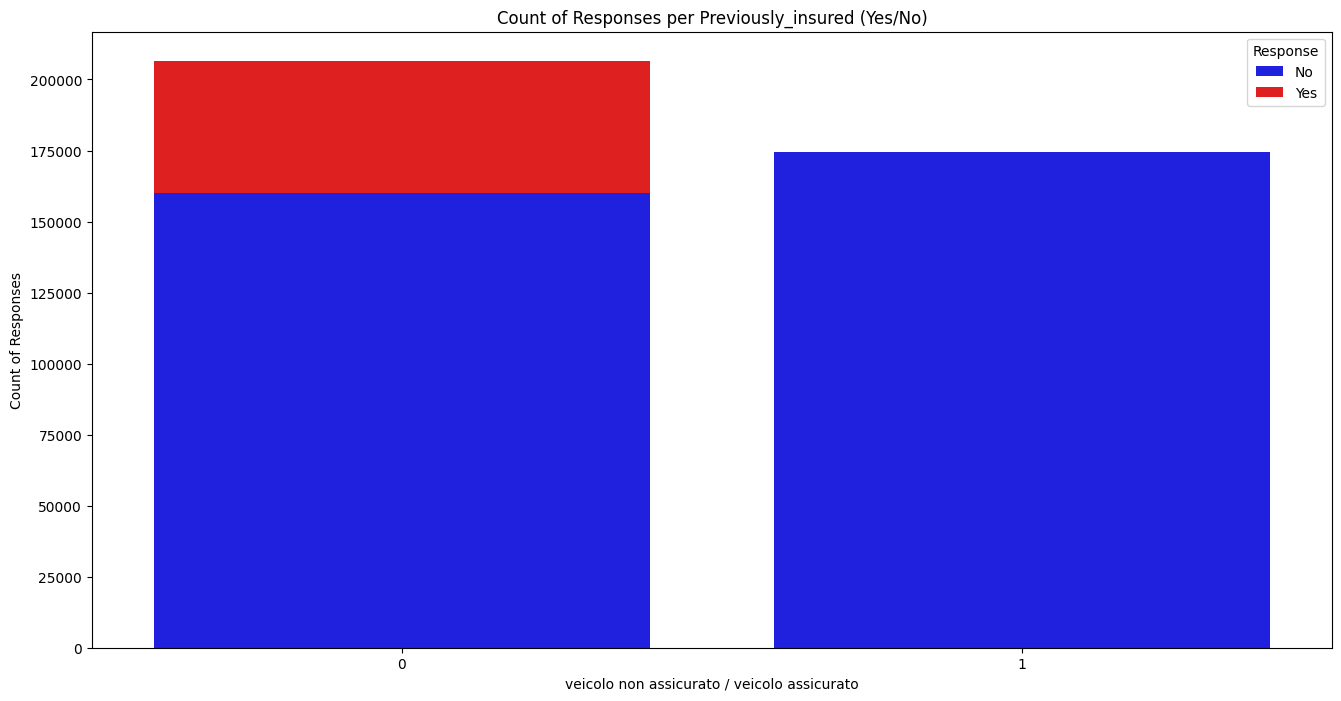

In [136]:
response_counts_Previously_Insured = pd.crosstab(df['Previously_Insured'], df['Response'])

response_counts_Previously_Insured.columns = ['No', 'Yes']

plt.figure(figsize=(16, 8))

sns.barplot(x=response_counts_Previously_Insured.index, y=response_counts_Previously_Insured['No'], color='blue', label='No')

sns.barplot(x=response_counts_Previously_Insured.index, y=response_counts_Previously_Insured['Yes'], color='red', label='Yes', bottom=response_counts_Previously_Insured['No'])

plt.xlabel('veicolo non assicurato / veicolo assicurato')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Previously_insured (Yes/No)')
plt.xticks(rotation=0)
plt.legend(title='Response')

plt.show()

In [137]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(response_counts_Previously_Insured)

contributions = (response_counts_Previously_Insured - expected) ** 2 / expected

contributions['Total'] = contributions.sum(axis=1)

contributions_sorted = contributions['Total'].sort_values(ascending=False)

print("Contributo Individuale al Chi-Quadro per Classe:")
with pd.option_context('display.max_rows', None):
    print(contributions_sorted)

significant_cells_response_counts_Previously_Insured = contributions[contributions>0.05*chi2_stat]
print(significant_cells_response_counts_Previously_Insured)

Contributo Individuale al Chi-Quadro per Classe:
Previously_Insured
1    24033.827713
0    20326.225008
Name: Total, dtype: float64
                             No           Yes         Total
Previously_Insured                                         
0                   2491.250456  17834.974552  20326.225008
1                   2945.666706  21088.161008  24033.827713


## Analisi variabili categoriche in realazione a Response: Vehicle_Damage

procediamo come al solito andando prima a plottare il grafico e successivamente i valori per il test del chi quadro per variabile. In questo caso la variabile non é stata ancodata trattandosi di una variabile binaria sará sufficente o mapparla con un si e con un no o usare il label encoding.



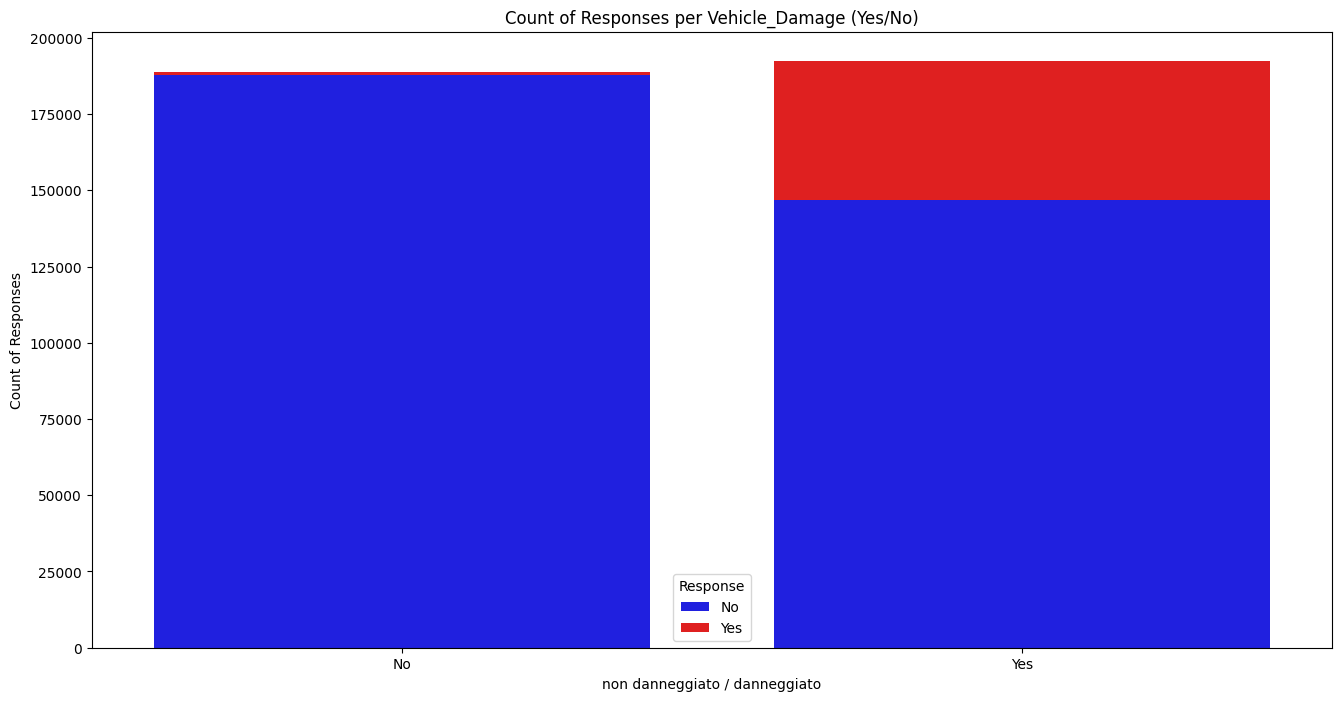

In [138]:
response_counts_Vehicle_Damage= pd.crosstab(df['Vehicle_Damage'], df['Response'])

response_counts_Vehicle_Damage.columns= ['No', 'Yes']

plt.figure(figsize=(16, 8))

sns.barplot(x=response_counts_Vehicle_Damage.index, y=response_counts_Vehicle_Damage['No'], color='blue', label='No')

sns.barplot(x=response_counts_Vehicle_Damage.index, y=response_counts_Vehicle_Damage['Yes'], color='red', label='Yes', bottom=response_counts_Vehicle_Damage['No'])

plt.xlabel('non danneggiato / danneggiato')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Vehicle_Damage (Yes/No)')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.show()

In [139]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(response_counts_Vehicle_Damage)

contributions = (response_counts_Vehicle_Damage - expected) ** 2 / expected

contributions['Total'] = contributions.sum(axis=1)

contributions_sorted = contributions['Total'].sort_values(ascending=False)

print("Contributo Individuale al Chi-Quadro per Classe:")
with pd.option_context('display.max_rows', None):
    print(contributions_sorted)

significant_cells_response_counts_Vehicle_Damage = contributions[contributions>0.05*chi2_stat]
print(significant_cells_response_counts_Vehicle_Damage)

Contributo Individuale al Chi-Quadro per Classe:
Vehicle_Damage
No     24166.887449
Yes    23700.035830
Name: Total, dtype: float64
                         No           Yes         Total
Vehicle_Damage                                         
No              2961.974954  21204.912495  24166.887449
Yes             2904.756050  20795.279779  23700.035830


Manteniamo anche questa variabile e andiamo a trasformarla con label encoding.

In [140]:
lb = LabelEncoder()
df['Vehicle_Damage'] = lb.fit_transform(df['Vehicle_Damage'])

In [141]:
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,is_region_28,is_channel_26.0,is_channel_124.0,is_channel_152.0,is_channel_160.0
id,,,,,,,,,,,,,
1,Male,44,1,0,2,1,40454.0,1,1,1,0,0,0
2,Male,76,1,0,1,0,33536.0,0,0,1,0,0,0
3,Male,47,1,0,2,1,38294.0,1,1,1,0,0,0
4,Male,21,1,1,0,0,28619.0,0,0,0,0,1,0
5,Female,29,1,1,0,0,27496.0,0,0,0,0,1,0


## Analisi variabili categoriche in realazione a Response: Gender

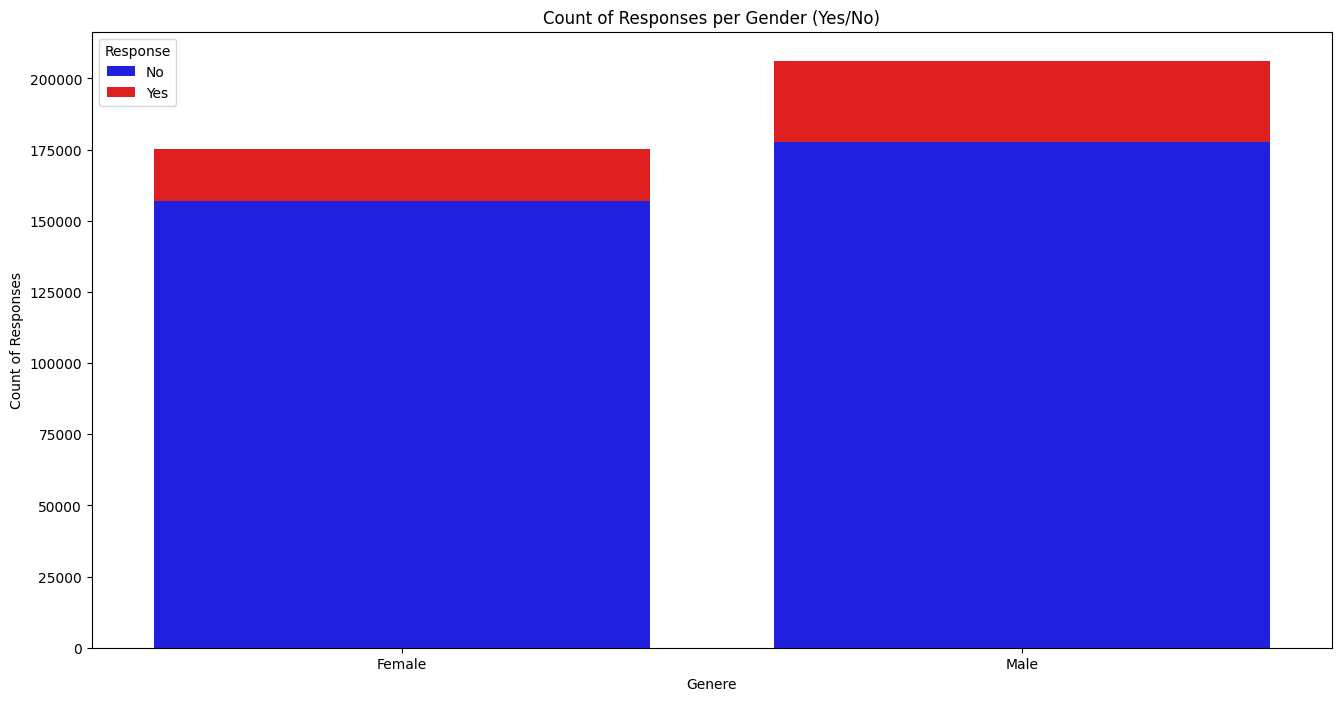

In [142]:
response_counts_Gender= pd.crosstab(df['Gender'], df['Response'])
response_counts_Gender.columns= ['No', 'Yes']
plt.figure(figsize=(16, 8))
sns.barplot(x=response_counts_Gender.index, y=response_counts_Gender['No'], color='blue', label='No')
sns.barplot(x=response_counts_Gender.index, y=response_counts_Gender['Yes'], color='red', label='Yes', bottom=response_counts_Gender['No'])
plt.xlabel('Genere')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Gender (Yes/No)')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.show()

In [143]:
lb = LabelEncoder()
df['Gender'] = lb.fit_transform(df['Gender'])
df

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,is_region_28,is_channel_26.0,is_channel_124.0,is_channel_152.0,is_channel_160.0
id,,,,,,,,,,,,,
1,1,44,1,0,2,1,40454.0,1,1,1,0,0,0
2,1,76,1,0,1,0,33536.0,0,0,1,0,0,0
3,1,47,1,0,2,1,38294.0,1,1,1,0,0,0
4,1,21,1,1,0,0,28619.0,0,0,0,0,1,0
5,0,29,1,1,0,0,27496.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381105,1,74,1,1,1,0,30170.0,0,0,1,0,0,0
381106,1,30,1,1,0,0,40016.0,0,0,0,0,1,0
381107,1,21,1,1,0,0,35118.0,0,0,0,0,0,1


## Analisi variabili categoriche in realazione a Response: Driving_License

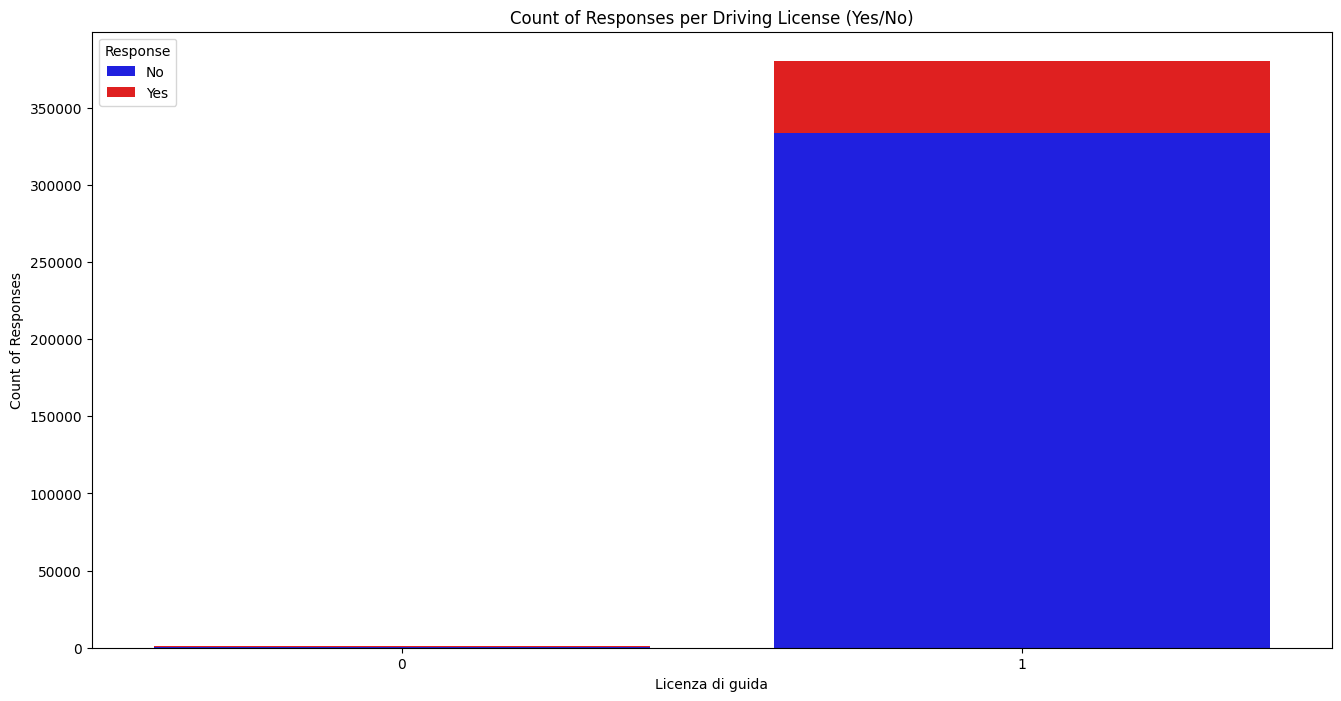

In [144]:
response_counts_Driving_license = pd.crosstab(df['Driving_License'], df['Response'])
response_counts_Driving_license.columns = ['No', 'Yes']
plt.figure(figsize=(16, 8))
sns.barplot(x=response_counts_Driving_license.index, y=response_counts_Driving_license['No'], color='blue', label='No')
sns.barplot(x=response_counts_Driving_license.index, y=response_counts_Driving_license['Yes'], color='red', label='Yes', bottom=response_counts_Driving_license['No'])
plt.xlabel('Licenza di guida')
plt.ylabel('Count of Responses')
plt.title('Count of Responses per Driving License (Yes/No)')
plt.xticks(rotation=0)
plt.legend(title='Response')
plt.show()

In [145]:
contingency_table_Driving_License = pd.crosstab(df['Driving_License'], df['Response'])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table_Driving_License)
contributions = (contingency_table_Driving_License - expected) ** 2 / expected
contributions['Total'] = contributions.sum(axis=1)
contributions_sorted = contributions['Total'].sort_values(ascending=False)

print("Contributo Individuale al Chi-Quadro per Classe:")
print(contributions_sorted)
print(contingency_table_Driving_License)

Contributo Individuale al Chi-Quadro per Classe:
Driving_License
0    39.219106
1     0.083740
Name: Total, dtype: float64
Response              0      1
Driving_License               
0                   771     41
1                333628  46669


### CREAZIONE DEL MODELLO

In [146]:
X = df.drop('Response', axis=1)

y = df['Response']

In [147]:
# Assegnazione delle variabili numeriche e categoriali
numeric_features = ['Age', 'Annual_Premium']
categorical_features = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age',
                        'Vehicle_Damage', 'is_region_28', 'is_channel_26.0', 'is_channel_124.0',
                        'is_channel_152.0', 'is_channel_160.0']

# Creazione del preprocessor per gestire le feature numeriche (scaling) e categoriali (passaggio diretto)
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Standardizza solo le feature numeriche
        ('cat', 'passthrough', categorical_features)  # Lascia passare direttamente le feature categoriali
    ]
)

# Splitting in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Configurazioni di SMOTE da testare
smote_config1 = {'sampling_strategy': 1.0, 'k_neighbors': 5}
smote_config2 = {'sampling_strategy': 1.0, 'k_neighbors': 10}

# Differenti pesi da testare
class_weights1 = {0: 1, 1: 15}
class_weights2 = {0: 1, 1: 20}
class_weights3 = 'balanced'

# Range di soglie da testare
threshold1 = 0.8
threshold2 = 0.75
threshold3 = 0.5

# Creazione dei modelli con i settaggi appositi
log_r_1 = LogisticRegression(max_iter=1000, class_weight=class_weights1)
log_r_2 = LogisticRegression(max_iter=1000, class_weight=class_weights1)
log_r_3 = LogisticRegression(max_iter=1000, class_weight=class_weights3)

# Calibrazione dei modelli
calibrated_model1 = CalibratedClassifierCV(log_r_1, method='sigmoid', cv=5)
calibrated_model2 = CalibratedClassifierCV(log_r_2, method='sigmoid', cv=5)
calibrated_model3 = CalibratedClassifierCV(log_r_3, method='sigmoid', cv=5)

# Creazione delle pipeline
pipeline1 = ImbPipeline([
    ('preprocessor', preprocessor1),
    ('smote', SMOTE(**smote_config2)),
    ('calibrated', calibrated_model1)
])

pipeline2 = ImbPipeline([
    ('preprocessor', preprocessor1),
    ('smote', SMOTE(**smote_config2)),
    ('calibrated', calibrated_model2)
])

pipeline3 = ImbPipeline([
    ('preprocessor', preprocessor1),
    ('smote', SMOTE(**smote_config2)),
    ('calibrated', calibrated_model3)
])

# Cross validation e calcolo delle probabilità
y_train_pred_prob_cross1 = cross_val_predict(pipeline1, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_train_pred_prob_cross2 = cross_val_predict(pipeline2, X_train, y_train, cv=5, method='predict_proba')[:, 1]
y_train_pred_prob_cross3 = cross_val_predict(pipeline3, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Probabilità filtrate per le rispettive threshold
y_train_pred_cross1 = (y_train_pred_prob_cross1 > threshold1).astype(int)
y_train_pred_cross2 = (y_train_pred_prob_cross2 > threshold2).astype(int)
y_train_pred_cross3 = (y_train_pred_prob_cross3 > threshold3).astype(int)

# Valutazione sulla cross-validation per ogni modello
cv_accuracy_1 = accuracy_score(y_train, y_train_pred_cross1)
cv_accuracy_2 = accuracy_score(y_train, y_train_pred_cross2)
cv_accuracy_3 = accuracy_score(y_train, y_train_pred_cross3)

cv_precision_1 = precision_score(y_train, y_train_pred_cross1, zero_division=0)
cv_precision_2 = precision_score(y_train, y_train_pred_cross2, zero_division=0)
cv_precision_3 = precision_score(y_train, y_train_pred_cross3, zero_division=0)

cv_recall_1 = recall_score(y_train, y_train_pred_cross1)
cv_recall_2 = recall_score(y_train, y_train_pred_cross2)
cv_recall_3 = recall_score(y_train, y_train_pred_cross3)

cv_f1_1 = f1_score(y_train, y_train_pred_cross1)
cv_f1_2 = f1_score(y_train, y_train_pred_cross2)
cv_f1_3 = f1_score(y_train, y_train_pred_cross3)

# Addestramento dei modelli sul train set completo
pipeline1.fit(X_train, y_train)
pipeline2.fit(X_train, y_train)
pipeline3.fit(X_train, y_train)

# Predizioni sul test set
y_test_pred_prob_test1 = pipeline1.predict_proba(X_test)[:, 1]
y_test_pred_prob_test2 = pipeline2.predict_proba(X_test)[:, 1]
y_test_pred_prob_test3 = pipeline3.predict_proba(X_test)[:, 1]

# Previsioni con le rispettive soglie
y_test_pred_1 = (y_test_pred_prob_test1 > threshold1).astype(int)
y_test_pred_2 = (y_test_pred_prob_test2 > threshold2).astype(int)
y_test_pred_3 = (y_test_pred_prob_test3 > threshold3).astype(int)

# Calcolo delle metriche di valutazione
cv_accuracy_1_test = accuracy_score(y_test, y_test_pred_1)
cv_accuracy_2_test = accuracy_score(y_test, y_test_pred_2)
cv_accuracy_3_test = accuracy_score(y_test, y_test_pred_3)

cv_precision_1_test = precision_score(y_test, y_test_pred_1)
cv_precision_2_test = precision_score(y_test, y_test_pred_2)
cv_precision_3_test = precision_score(y_test, y_test_pred_3)

cv_recall_1_test = recall_score(y_test, y_test_pred_1)
cv_recall_2_test = recall_score(y_test, y_test_pred_2)
cv_recall_3_test = recall_score(y_test, y_test_pred_3)

cv_f1_1_test = f1_score(y_test, y_test_pred_1)
cv_f1_2_test = f1_score(y_test, y_test_pred_2)
cv_f1_3_test = f1_score(y_test, y_test_pred_3)

# Valutazione dei modelli sul test set
print('VALUTAZIONE DEI MODELLI')
print(f"Cross validation modello 1: pesi ({class_weights1}), SMOTE ({smote_config1}), Threshold ({threshold1})")
print(f'CV Accuracy: {cv_accuracy_1:.4f}')
print(f'CV Precision: {cv_precision_1:.4f}')
print(f'CV Recall: {cv_recall_1:.4f}')
print(f'CV F1 Score: {cv_f1_1:.4f}')
print(f"Valutazione modello 1: pesi ({class_weights1}), SMOTE ({smote_config1}), Threshold ({threshold1})")
print(f'Test Accuracy: {cv_accuracy_1_test:.4f}')
print(f'Precision: {cv_precision_1_test:.4f}')
print(f'Recall: {cv_recall_1_test:.4f}')
print(f'F1 Score: {cv_f1_1_test:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_test_pred_1, digits=4))

print(f"Cross validation modello 2: pesi ({class_weights1}), SMOTE ({smote_config2}), Threshold ({threshold2})")
print(f'CV Accuracy: {cv_accuracy_2:.4f}')
print(f'CV Precision: {cv_precision_2:.4f}')
print(f'CV Recall: {cv_recall_2:.4f}')
print(f'CV F1 Score: {cv_f1_2:.4f}')
print(f"Valutazione modello 2: pesi ({class_weights2}), SMOTE ({smote_config2}), Threshold ({threshold2})")
print(f'Test Accuracy: {cv_accuracy_2_test:.4f}')
print(f'Precision: {cv_precision_2_test:.4f}')
print(f'Recall: {cv_recall_2_test:.4f}')
print(f'F1 Score: {cv_f1_2_test:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_test_pred_2, digits=4))

print(f"Cross validation modello 3: pesi ({class_weights3}), SMOTE ({smote_config2}), Threshold ({threshold3})")
print(f'CV Accuracy: {cv_accuracy_3:.4f}')
print(f'CV Precision: {cv_precision_3:.4f}')
print(f'CV Recall: {cv_recall_3:.4f}')
print(f'CV F1 Score: {cv_f1_3:.4f}')
print(f"Valutazione modello 3: pesi ({class_weights3}), SMOTE ({smote_config2}), Threshold ({threshold3})")
print(f'Test Accuracy: {cv_accuracy_3_test:.4f}')
print(f'Precision: {cv_precision_3_test:.4f}')
print(f'Recall: {cv_recall_3_test:.4f}')
print(f'F1 Score: {cv_f1_3_test:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_test_pred_3, digits=4))


VALUTAZIONE DEI MODELLI
Cross validation modello 1: pesi ({0: 1, 1: 15}), SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 5}), Threshold (0.8)
CV Accuracy: 0.8613
CV Precision: 0.3396
CV Recall: 0.1392
CV F1 Score: 0.1975
Valutazione modello 1: pesi ({0: 1, 1: 15}), SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 5}), Threshold (0.8)
Test Accuracy: 0.8607
Precision: 0.3317
Recall: 0.1344
F1 Score: 0.1913

Classification Report:
               precision    recall  f1-score   support

           0     0.8884    0.9622    0.9238    100320
           1     0.3317    0.1344    0.1913     14013

    accuracy                         0.8607    114333
   macro avg     0.6101    0.5483    0.5576    114333
weighted avg     0.8201    0.8607    0.8340    114333

Cross validation modello 2: pesi ({0: 1, 1: 15}), SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 10}), Threshold (0.75)
CV Accuracy: 0.8180
CV Precision: 0.3333
CV Recall: 0.4849
CV F1 Score: 0.3951
Valutazione modello 2: pesi ({0: 1, 1

### CONCLUSIONI
Dai diversi test volti possiamo dire che i modelli non soffrono di overfitting, i risultati in cross validation sono pressoché allineati con le valutazioni del test set; possiamo oltresi affermare che il modello migliore va valutato in base alla nostre esigenze.
L'obbiettivo é prevedere la Response per facilitare l'aquisizione di nuovi clienti applicando politiche di marketing atte a trasformare un cliente potenziale in un cliente effettivo; i modelli selezionati nella fattispecie sono quelli con i seguenti parametri.

Cross validation modello 1:

pesi ({0: 1, 1: 15}),

SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 5}),

Threshold (0.8)

VALUTAZIONE IN CROSS  VALIDATION MODELLO 1

CV Accuracy: 0.8609
CV Precision: 0.3360
CV Recall: 0.1385
CV F1 Score: 0.1962

Valutazione modello 1:
pesi ({0: 1, 1: 15}),
SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 5}),
Threshold (0.8)

VALUTAZIONE SUL TEST SET MODELLO 1

Test Accuracy: 0.8612
Precision: 0.3340
Recall: 0.1332
F1 Score: 0.1905

Classification Report:
               precision    recall  f1-score   support

           0     0.8883    0.9629    0.9241    100320
           1     0.3340    0.1332    0.1905     14013

    accuracy                         0.8612    114333
   macro avg     0.6111    0.5481    0.5573    114333
weighted avg     0.8204    0.8612    0.8342    114333

Cross validation modello 2:

pesi ({0: 1, 1: 15}),

SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 10}),

Threshold (0.75)

VALUTAZIONE IN CROSS  VALIDATION MODELLO 2

CV Accuracy: 0.8175
CV Precision: 0.3319
CV Recall: 0.4829
CV F1 Score: 0.3934

Valutazione modello 2:
pesi ({0: 1, 1: 20}),
SMOTE ({'sampling_strategy': 1.0, 'k_neighbors': 10}),
Threshold (0.75)

VALUTAZIONE SUL TEST SET MODELLO 2

Test Accuracy: 0.8194
Precision: 0.3361
Recall: 0.4856
F1 Score: 0.3973

Classification Report:
               precision    recall  f1-score   support

           0     0.9234    0.8660    0.8938    100320
           1     0.3361    0.4856    0.3973     14013

    accuracy                         0.8194    114333
   macro avg     0.6297    0.6758    0.6455    114333
weighted avg     0.8514    0.8194    0.8329    114333




Questi modelli Hanno fatto registrare score di precision e recall ottime per 0 e basse per 1 in maniera particolarmente significativa per quanto concerne il secondo modello. L'utilizzo di uno rispetto all'altro dipende dall'obbiettivo che ci prefissiamo. In linea generale il secondo modello se pur sacrificando un 10% in recall ha una precision piú alta nel rilevare la classe 0, e le valutazioni in termini di precision e recall della classe 1 sono notevolmente piú alte rispetto al primo modello che riesce unicamente a riconoscere il 13% dei valori realmente 1 presenti nei dati (recall 0.13). Dovendo scegliere tra i due opterei per il secondo modello.
In ottica di business questo modello ci permette di valutare con una buona precisione i clienti che non sono inclini ad accettare nuove polizze assicurative di conseguenza possiamo facilmente indirizzare il marketing verso un target di mercato (1) maggiormente propenso a nuove offerte, massimizzando i tempi e i guadagni.